# **Импорт необходимых библиотек**

In [ ]:
from scipy import stats
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as sm
import statsmodels.api as st
from statsmodels.stats.stattools import durbin_watson

# **Тестирование гипотез**

1. Проверим гипотезу о нормальности распределения цен акций Сбербанка с помощью теста Шапиро-Уилка

In [ ]:
#https://www.codecamp.ru/blog/shapiro-wilk-test-python/
statistic, p_value = stats.shapiro(df['Цена_СБ'])
print("Статистика теста:", statistic)
print("p-значение:", p_value)

# Оценка нормальности данных на основе p-значения
alpha = 0.05  # Уровень значимости
if p_value > alpha:
    print("Данные похожи на нормальное распределение")
else:
    print("Данные не похожи на нормальное распределение")

Статистика теста: 0.9019277095794678
p-значение: 2.710802502609022e-13
Данные не похожи на нормальное распределение


Наша гипотеза будет отвергаться на любом уровне значимости, поскольку pvalue велико, поэтому потребуется нормализация.

2. Проверим гипотезу о стационарости временного ряда, чтобы посмотреть, не меняются ли основные статистические характеристики цен акций во времени.
**Нулевая гипотеза:** ряд нестационарен.

**Альтернативная гипотеза:** ряд стационарен

In [ ]:
result = adfuller(df["Цена_СБ"])
print("Статистика теста:", result[0])
print("P-значение:", result[1])
print("Критические значения:", result[4])
if result[1] < 0.05:
    print("Отклоняем нулевую гипотезу - ряд стационарен")
else:
    print("Не отклоняем нулевую гипотезу - ряд нестационарен")

Статистика теста: 0.8083743612950619
P-значение: 0.9917701503430552
Критические значения: {'1%': -3.45169128009473, '5%': -2.8709394227049154, '10%': -2.5717780602423517}
Не можем отклонить нулевую гипотезу - ряд нестационарен


Вывод: ряд цен акций Сбербанка будет необходимо сделать стационарным

3. Проверим выдвинутую ранее гипотезу о взаимосвязи между концом квартала и ценами акций с помощью t-теста и регрессионного анализа
**Нулевая гипотеза:** в цене акций в дни окончания квартала нет значимой разницы

**Альтернативная гипотеза:** в цене акций в дни окончания квартала есть значимая разница

In [ ]:
group1 = df["Цена_СБ"][df["is_quarter_end"] == 1]
group2 = df["Цена_СБ"][df["is_quarter_end"] == 0]

# Выполняем t-тест
result = stats.ttest_ind(group1, group2)

# Выводим результаты
print("Статистика теста:", result.statistic)
print("P-значение:", result.pvalue)

# Интерпретация результатов
if result.pvalue < 0.05:
    print("Отклоняем нулевую гипотезу - есть значимая разница в цене акции в дни окончания квартала")
else:
    print("Не можем отклонить нулевую гипотезу - нет значимой разницы в цене акции в дни окончания квартала")

Статистика теста: -0.10080524779308873
P-значение: 0.9197706480513388
Не можем отклонить нулевую гипотезу - нет значимой разницы в цене акции в дни окончания квартала


In [ ]:
#https://habr.com/ru/articles/690414/
model = sm.ols("Цена_СБ ~ is_quarter_end", data=df)
results = model.fit()
print(results.summary())
if results.pvalues["is_quarter_end"] < 0.05:
    print("Конец квартала значимо влияет на цену акции")
else:
    print("Конец квартала незначительно влияет на цену акции")

                            OLS Regression Results                            
Dep. Variable:                Цена_СБ   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                   0.01016
Date:                Sun, 02 Jun 2024   Prob (F-statistic):              0.920
Time:                        13:57:23   Log-Likelihood:                -1620.7
No. Observations:                 310   AIC:                             3245.
Df Residuals:                     308   BIC:                             3253.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        246.1308      3.004     81.

Наше предположение о том, что дни окончания квартала влияют на динамику цен акций ПАО Сбербанк,не подтвердилось.Скорее всего это связано с финансовой стабильностью компании и её политикой по отношению к инвесторам (например, Сбербанк часто публикует промежуточные результаты деятельности компании в ТГ-канале),что позволяет инвестором закладывать позитивные ожидания в цены акций заранее, и новость о публикации компанией ежеквартальной отчетности не отыгрывается на рынке так, как у компаний, которые осуществляют иную политику.

4. Протестируем гипотезу о влиянии на цены акций ПАО Сбербанк ключевой ставки ЦБ РФ с помощью построения регрессионной модели
**Нулевая гипотеза:** нет существенного влияния ключевой ставки на цены акций Сбербанка

**Альтернативная гипотеза:** ключевая ставка существенно влияет на цены акций Сбербанка

In [ ]:
X = st.add_constant(df['Ключевая ставка,%'])
y = df['Цена_СБ']
model = st.OLS(y, X).fit()
print(model.summary())
if model.pvalues["Ключевая ставка,%"] < 0.05:
    print("Ключевая ставка значимо влияет на цены акций Сбербанка")
else:
    print("Ключевая ставка не оказывает существенного влияние на цены акций Сбербанка")

                            OLS Regression Results                            
Dep. Variable:                Цена_СБ   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     596.4
Date:                Sun, 02 Jun 2024   Prob (F-statistic):           5.10e-74
Time:                        13:54:48   Log-Likelihood:                -1453.8
No. Observations:                 310   AIC:                             2912.
Df Residuals:                     308   BIC:                             2919.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               133.3020      4.85

Коэффициент детерминации достаточно высок (приблизительно 0.7). Известно, что чем ближе данный коэффициент к 1, тем лучше у нас объясняется изменчивость данных, а значит, лучше объясняется влияние одного показателя на другой. В целом, выдвинутое нами предположение о влиянии ключевой ставки при исследовательском анализе данных подтвердилось, и данные по ключевой ставке будут полезны при обучении модели.

5. Проверим гипотезу об автокорреляции цен акций ПАО Сбербанк, поскольку при работе с данными финансового сектора этот фактор важно учитывать для точности выводов и прогнозов

In [ ]:
dw_statistic = durbin_watson(df['Цена_СБ'])
print("Статистика теста Дарбина-Уотсона:", dw_statistic)
if dw_statistic < 1.5:
    print("Положительная автокорреляция")
elif dw_statistic > 2.5:
    print("Отрицательная автокорреляция")
else:
    print("Нет автокорреляции")

Статистика теста Дарбина-Уотсона: 0.00015738278250138782
Положительная автокорреляция


**Вывод:** между ценами акций в разный момент времени существует положительная зависимость. Например, если цена акций сегодня выше, чем вчера, то вероятность того, что цена акций завтра также будет выше, увеличивается. Также результат нашего теста может свидетельствовать о наличии тенденций в формировании цен.

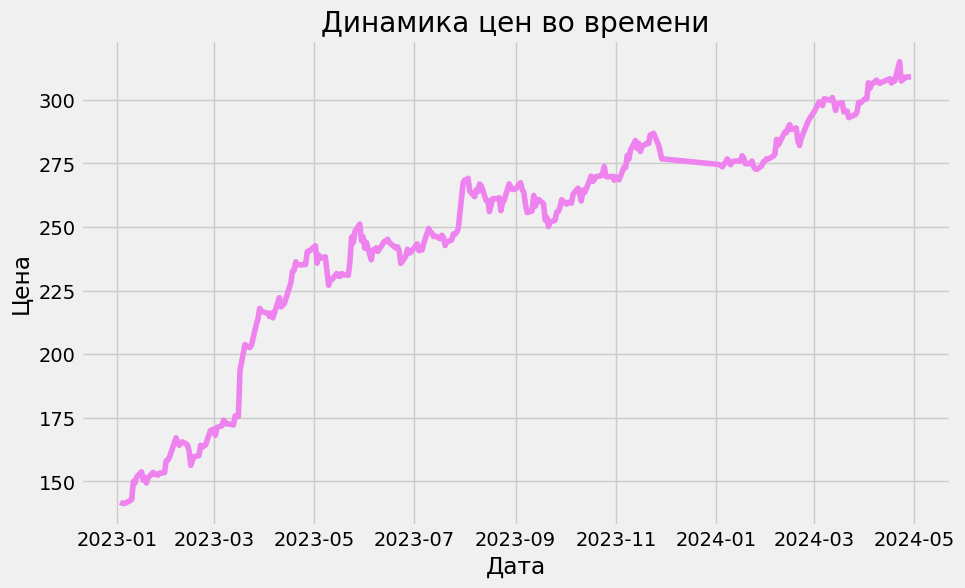

In [ ]:
df = df.sort_values(by='Дата', ascending=False)
plt.figure(figsize=(10, 6))
plt.plot(df['Дата'], df['Цена_СБ'], color = 'violet')
plt.title('Динамика цен во времени')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.show()

Тренд роста действительно есть.

6. Проверим гипотезу о том,что в понедельник и пятницу в цены акций закладываются ожидания относительно выходных или же отыгрываются новости,произошедшие за субботу и воскресенье. Если это так, то средние значения должны существенно различаться. В качестве бенчмарка примем индекс IMOEX, поскольку он диверсифицирован и вполне отражает рыночную ситуацию.

In [ ]:
df['День недели'] = df['День недели'].replace({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday'})
monday_friday_data = df[(df['День недели'] == 'Monday') | (df['День недели'] == 'Friday')]
other_days_data = df[(df['День недели'] != 'Monday') & (df['День недели'] != 'Friday')]
mean_prices_monfri = monday_friday_data['Цена_СБ'].mean()
mean_prices_other = other_days_data['Цена_СБ'].mean()
mean_index_prices_monfri = monday_friday_data['Цена_М'].mean()
mean_index_prices_other = other_days_data['Цена_М'].mean()
t_statistic, p_value = stats.ttest_ind(monday_friday_data['Цена_СБ'], other_days_data['Цена_СБ'], equal_var = False)

print(f"Средняя цена акций в понедельник и пятницу: {mean_prices_monfri}")
print(f"Средняя цена акций в другие дни: {mean_prices_other}")
print(f"Средняя цена индекса в понедельник и пятницу: {mean_index_prices_monfri}")
print(f"Средняя цена индекса в другие дни: {mean_index_prices_other}")
print(f"Значение t-статистики: {t_statistic}, p-значение: {p_value}")

Средняя цена акций в понедельник и пятницу: 246.0871544715447
Средняя цена акций в другие дни: 245.89973262032086
Средняя цена индекса в понедельник и пятницу: 86.75472682926828
Средняя цена индекса в другие дни: 86.80456470588234
Значение t-статистики: 0.035579741230349404, p-значение: 0.9716448719716615


Можем увидеть, что среднее значение цен акций Сбербанка в понедельник и пятницу чуть выше, чем в остальные дни, однако эта разница несущественная.

- Значение t-статистики равно 0.0356. Это говорит о том, что различия между средними значениями двух групп невелики.
- p-значение составляет 0.9716. Это означает, что вероятность получить такие же или более экстремальные различия между группами при условии, что нулевая гипотеза верна, очень высока.

Итак, мы не можем отвергнуть нулевую гипотезу о том, что средние значения двух групп одинаковы.

Таким образом, на основании этих результатов можно сделать вывод, что нет статистически значимых различий между ценами акций Сбербанка и ценами индекса IMOEX в понедельник и пятницу, и значит, что в целом, цены акций вполне справедливы